In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset
dataset = load_dataset("cnn_dailymail", version="3.0.0")
print(f"Features: {dataset['train'].column_names}")

Features: ['article', 'highlights', 'id']


In [ ]:
sample = dataset["train"][1]
print(f"""
Article (excerpt of 500 characters, total length: {len(sample["article"])}):
""")
print(sample["article"][:500])
print(f'\nSummary (length: {len(sample["highlights"])}):')
print(sample["highlights"])


Article (excerpt of 500 characters, total length: 4051):

Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most s

Summary (length: 281):
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .


In [ ]:
sample_text = dataset["train"][1]["article"][:2000]
# We'll collect the generated summaries of each model in a dictionary
summaries = {}

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize
nltk.download("punkt")
string = "The U.S. are a country. The U.N. is an organization."
sent_tokenize(string)
['The U.S. are a country.', 'The U.N. is an organization.']

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['The U.S. are a country.', 'The U.N. is an organization.']

A common baseline for summarizing news articles is to simply take the first three
sentences of the article

In [ ]:
def three_sentence_summary(text):
  return "\n".join(sent_tokenize(text)[:3])
summaries["baseline"] = three_sentence_summary(sample_text)
print(summaries)

{'baseline': 'Editor\'s note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.\nHere, Soledad O\'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.\nMIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."'}


In [ ]:
!pip install transformers

  Using cached tokenizers-0.13.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.8 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.14.0
    Uninstalling tokenizers-0.14.0:
      Successfully uninstalled tokenizers-0.14.0


###GPT2

In [ ]:
from transformers import pipeline, set_seed
set_seed(42)
pipe = pipeline("text-generation", model="gpt2")
gpt2_query = sample_text + "\nTL;DR:\n" # Too long, didn't read
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)
summaries["gpt2"] = "\n".join(
    sent_tokenize(pipe_out[0]["generated_text"][len(gpt2_query) :]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


###T5

In [ ]:
pipe = pipeline("summarization", model="t5-base")
pipe_out = pipe(sample_text)
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5_fast.py:158: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


###Bart

In [ ]:
pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

In [ ]:
!pip install sentencepiece

In [ ]:
!pip install tokenizers --upgrade

  Using cached tokenizers-0.14.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.8 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.13.3
    Uninstalling tokenizers-0.13.3:
      Successfully uninstalled tokenizers-0.13.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.33.2 requires tokenizers!=0.11.3,<0.14,>=0.11.1, but you have tokenizers 0.14.0 which is incompatible.


###PEGASUS
Its pretraining objective is to predict masked sentences in multisentence texts,

sentences containing most of the content of their surrounding
paragraphs


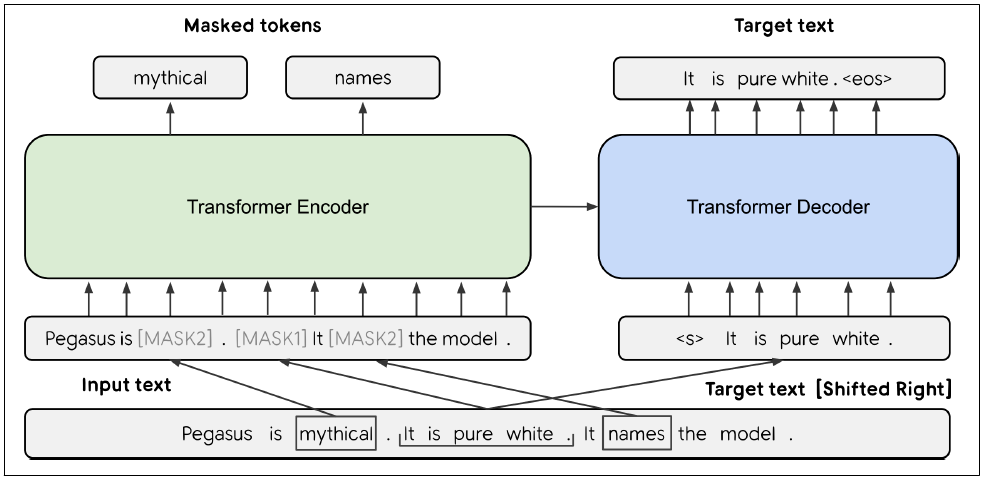

In [ ]:
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")
pipe_out = pipe(sample_text)
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(" .<n>", ".\n")

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


###Comparing Different Summaries
one model has not been trained on the dataset at all
(GPT-2), one model has been fine-tuned on this task among others (T5), and two
models have exclusively been fine-tuned on this task (BART and PEGASUS).

In [ ]:
summaries

{'baseline': 'Editor\'s note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.\nHere, Soledad O\'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.\nMIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."',
 'gpt2': "\nTo be clear, prisoners who feel like they can't go to the other side of the court do not actually face the law, he says.\nInstead, they are detained and charged with a crime.\nMany prisoners in these cases can't even begin to speak about their illnesses while being restrained.\nLeifman says there are no special protections about prisoners in jail.\nThey have an unlimited",
 't5': 'mentally ill inmates housed on the "forgotten floor" of a pretrial detention facility in florida .\ninmates with 

In [ ]:
!pip install tqdm
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 2.9 MB/s eta 0:00:00


###Measuring the Quality of Generated Text
we would define a metric, measure it for all models on some benchmark dataset, and choose the one
with the best performance.

In [ ]:
from datasets import load_metric
bleu_metric = load_metric("sacrebleu")

In [ ]:
import pandas as pd
import numpy as np
bleu_metric.add(prediction="the the the the the the", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[6, 5, 4, 3]"
precisions,"[33.33, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,6
ref_len,6


In [ ]:
bleu_metric.add(prediction="the cat is on mat", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,57.893007
counts,"[5, 3, 2, 1]"
totals,"[5, 4, 3, 2]"
precisions,"[100.0, 75.0, 66.67, 50.0]"
bp,0.818731
sys_len,5
ref_len,6


In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24932 sha256=a35894b3b2508b3169d66ce53a7b4fe231bc502e1dd77c099e2cee38cd8462b8
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
rouge_metric = load_metric("rouge")
reference = dataset["train"][1]["highlights"]
records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
for model_name in summaries:
  rouge_metric.add(prediction=summaries[model_name], reference=reference)
  score = rouge_metric.compute()
  rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
  records.append(rouge_dict)
pd.DataFrame.from_records(records, index=summaries.keys())

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.365079,0.145161,0.206349,0.285714
gpt2,0.258621,0.035088,0.120690,0.241379
t5,0.392157,0.140000,0.254902,0.352941
bart,0.475248,0.222222,0.316832,0.415842
pegasus,0.323232,0.206186,0.282828,0.323232


In [ ]:
def evaluate_summaries_baseline(dataset, metric, column_text="article", column_summary="highlights"):
  summaries = [three_sentence_summary(text) for text in dataset[column_text]]
  metric.add_batch(predictions=summaries,
  references=dataset[column_summary])
  score = metric.compute()
  return score

In [ ]:
test_sampled = dataset["test"].shuffle(seed=42).select(range(1000))
score = evaluate_summaries_baseline(test_sampled, rouge_metric)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient="index", columns=["baseline"]).T

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.389276,0.171296,0.245061,0.354239


###Evaluating PEGASUS on the CNN/DailyMail Dataset
1. we have a dataset with a test set from CNN/DailyMail,
2. we have a metric with ROUGE,
3. we have a summarization model.

In [ ]:
from tqdm import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

def chunks(list_of_elements, batch_size):
  """Yield successive batch-sized chunks from list_of_elements."""
  for i in range(0, len(list_of_elements), batch_size):
    yield list_of_elements[i : i + batch_size]

def evaluate_summaries_pegasus(dataset, metric, model, tokenizer,
                               batch_size=16, device=device,
                               column_text="article",
                               column_summary="highlights"):

  article_batches = list(chunks(dataset[column_text], batch_size))
  target_batches = list(chunks(dataset[column_summary], batch_size))
  for article_batch, target_batch in tqdm(
    zip(article_batches, target_batches), total=len(article_batches)):

    # tokenize the input articles
    inputs = tokenizer(article_batch, max_length=1024, truncation=True,
                       padding="max_length", return_tensors="pt")

    # feed them to the generate(), produce the summaries using beam search.
    summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                               attention_mask=inputs["attention_mask"].to(device),
                               length_penalty=0.8, num_beams=8, max_length=128)

    decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                          clean_up_tokenization_spaces=True) for s in summaries]
    decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
    metric.add_batch(predictions=decoded_summaries, references=target_batch)
  score = metric.compute()
  return score

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)
score = evaluate_summaries_pegasus(test_sampled, rouge_metric,
                                   model, tokenizer, batch_size=8)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 125/125 [25:03<00:00, 12.03s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.434435,0.216545,0.311912,0.374273


In [ ]:
!pip install py7zr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3/412.3 kB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.8/138.8 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 11.1 MB/s eta 0:00:00


##Training a Summarization Model
For our application, we’ll
use the SAMSum dataset developed by Samsung, which consists of a collection of dialogues
along with brief summaries,

The dialogues includes emojis and placeholders for GIFs. The dialogue field contains the full text
and the summary the summarized dialogue. Could a model that was fine-tuned on the
CNN/DailyMail dataset deal with that? Let’s find out!

In [ ]:
dataset_samsum = load_dataset("samsum")
split_lengths = [len(dataset_samsum[split])for split in dataset_samsum]
print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


In [ ]:
pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])
print("Summary:")
print(pipe_out[0]["summary_text"].replace(" .<n>", ".\n"))

Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Summary:
Amanda: Ask Larry Amanda: He called her last time we were at the park together.
Hannah: I'd rather you texted him.
Amanda: Just text him .


##Evaluating PEGASUS on SAMSum

In [ ]:
score = evaluate_summaries_pegasus(dataset_samsum["test"], rouge_metric, model,
                                   tokenizer, column_text="dialogue",
                                   column_summary="summary", batch_size=8)

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

100%|██████████| 103/103 [18:47<00:00, 10.95s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.296038,0.087469,0.229174,0.229574


Well, the results aren’t great, not unexpected since we’ve moved away from the CNN/DailyMail data distribution. Nevertheless, setting up the evaluation
pipeline before training has two advantages: we can directly measure the success
of training with the metric and we have a good baseline.

Fine-tuning the model on
our dataset should result in an immediate improvement in the ROUGE metric, and if
that is not the case we’ll know something is wrong with our training loop.

##Fine-Tuning PEGASUS

In [ ]:
# Before processing training data, quick look at the length distribution of the input and outputs
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

Based on the the token length for Dialogue (100–200 tokens) and summaries (20–40 tokens), we’ll set the maximum lengths to 1024
and 128 for the dialogues and summaries

In [ ]:
def convert_examples_to_features(example_batch):
  input_encodings = tokenizer(
      example_batch["dialogue"], max_length=1024, truncation=True)

  # Some models require special tokens in the decoder inputs, so it’s
  # important to differentiate between the tokenization of encoder and decoder inputs.
  # the tokenization strategy for inputs and targets may differ in certain scenarios.
  with tokenizer.as_target_tokenizer():
    target_encodings = tokenizer(
        example_batch["summary"],
        max_length=128,
        truncation=True)

    return {"input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]}

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched=True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

- In the context of training a PEGASUS model for summarization, a customized data collator is necessary. Unlike default collators, this one handles the specifics of the seq2seq architecture. For effective training, the decoder requires a "teacher forcing" approach, where input tokens consist of shifted labels. This ensures the decoder sees ground truth labels for predicting the next token. The batch preparation involves shifting labels to the right by one and handling padding tokens. The DataCollatorForSeq2Seq automates these steps, streamlining the process for training a PEGASUS model with a seq2seq setup.

- Gradient accumulation allows the model to effectively simulate the impact of a larger batch size while still working with smaller batches that fit into GPU memory. It's a trade-off between memory efficiency and training speed. The model updates less frequently, but the updates are based on a more stable estimate of the gradients, helping to achieve convergence even with limited GPU memory.

In [ ]:
from transformers import DataCollatorForSeq2Seq
from transformers import TrainingArguments, Trainer

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

training_args = TrainingArguments(
  output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
  per_device_train_batch_size=1, per_device_eval_batch_size=1,
  weight_decay=0.01, logging_steps=10, push_to_hub=True,
  evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
  gradient_accumulation_steps=16)

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
trainer = Trainer(model=model, args=training_args,
  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
  train_dataset=dataset_samsum_pt["train"],
  eval_dataset=dataset_samsum_pt["validation"])

In [ ]:
trainer.train()
score = evaluate_summaries_pegasus(
dataset_samsum["test"], rouge_metric, trainer.model, tokenizer,
batch_size=2, column_text="dialogue", column_summary="summary")
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=[f"pegasus"])

In [ ]:
trainer.push_to_hub("Training complete!")

###Generating Dialogue Summaries

In [ ]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]
pipe = pipeline("summarization", model="transformersbook/pegasus-samsum")

print("Dialogue:")
print(sample_text)
print("\nReference Summary:")
print(reference)
print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

In [ ]:
custom_dialogue = """\
  Thom: Hi guys, have you heard of transformers?
  Lewis: Yes, I used them recently!
  Leandro: Indeed, there is a great library by Hugging Face.
  Thom: I know, I helped build it ;)
  Lewis: Cool, maybe we should write a book about it. What do you think?
  Leandro: Great idea, how hard can it be?!
  Thom: I am in!
  Lewis: Awesome, let's do it together!
  """
print(pipe(custom_dialogue, **gen_kwargs)[0]["summary_text"])

There is no single strategy to solve this problem, and to date this is still
an open and active research question. Recent work by OpenAI showed how to scale summarization by applying it recursively to long documents and using human feedback in the loop.